In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import pdb
from adjustText import adjust_text
import pandas as pd
import os

In [32]:
def get_val_metrics(runs, exclude_keyword='ignore'):
    run_f1_scores = {}
    run_auroc_val_scores = {}
    exclude_keyword='ignore'
    for run in runs:
        # print(run.name)
        if exclude_keyword.lower() not in run.name.lower():

            history = run.history(pandas=True)
            # pdb.set_trace()
            # print(run.id)
            # pdb.set_trace()
            val_f1_scores = history['f1_test'].dropna().tolist()
            auroc_val_scores = history['auroc_test'].dropna().tolist()
            
            model_name_key = run.name.split('-')[2]
            if model_name_key in run_f1_scores:
                run_f1_scores[model_name_key].extend(val_f1_scores)
            else:
                run_f1_scores[model_name_key] = val_f1_scores
            
            if model_name_key in run_auroc_val_scores:
                run_auroc_val_scores[model_name_key].extend(auroc_val_scores)
            else:
                run_auroc_val_scores[model_name_key] = auroc_val_scores
    return run_f1_scores, run_auroc_val_scores

# def get_val_metrics_scan(runs, index=0, exclude_keyword='ignore'):
#     run_f1_scores = {}
#     run_auroc_val_scores = {}
    
#     for run in runs:
#         if exclude_keyword.lower() not in run.name.lower():
#             # Use scan_history() instead of history()
#             history_data = []
#             for row in run.scan_history(keys=["f1_val", "auroc_val"]):
#                 history_data.append(row)
            
#             # Convert to DataFrame
#             history = pd.DataFrame(history_data)
            
#             val_f1_scores = history['f1_val'].dropna().tolist()
#             auroc_val_scores = history['auroc_val'].dropna().tolist()
            
#             run_f1_scores[run.id] = val_f1_scores
#             run_auroc_val_scores[run.id] = auroc_val_scores
    
#     return list(run_f1_scores.values()), list(run_auroc_val_scores.values())

def get_mean_std_per_agg(scores):
    means = [np.mean([sublist[i] for sublist in scores]) for i in range(len(scores[0]))]
    stds = [np.std([sublist[i] for sublist in scores]) for i in range(len(scores[0]))]
    return np.max(means), stds[np.argmax(means)], np.argmax(means)

def get_max(scores):
    max_per_fold = [np.max(fold) for fold in scores]
    max_epochs = [np.argmax(fold) for fold in scores]
    return max_per_fold, max_epochs

MDL_COLOR = {
    'resnet50':'r',
    'uni':'b',
    'gigapath': 'g'
}



In [65]:


def plot_cross_validation_scores(f1_scores, 
                                 feature_encoders=['ResNet50', 'UNI', 'Prov-Gigapath'], 
                                 colors=['lightcoral', 'purple', 'teal'], 
                                 title='Best Cross-Validation F1-Scores per Feature Encoders Across MIL Algorithms', 
                                 xlabel='MIL Algorithms', 
                                 ylabel='F1-Score'):
    """
    Plot cross-validation scores for different models and feature encoders.
    
    Parameters:
    - f1_scores: dict, keys are model names, values are lists of tuples, 
                 where each tuple contains a list of best scores and a list of corresponding epochs.
    - feature_encoders: list, names of the feature encoders.
    - colors: list, colors for the box plots of each feature encoder.
    - title: str, title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    """
    
    models = list(f1_scores.keys())
    
    # Prepare data for plotting
    data = []
    positions = []
    epoch_ranges = []
    mean_scores = []
    for i, model in enumerate(models):
        for j, (scores) in enumerate(f1_scores[model]):
            data.append(scores)
            positions.append(i * (len(feature_encoders) + 1) + j + 1)
            # epoch_ranges.append((min(epochs), max(epochs)))
            mean_scores.append(np.mean(scores))

    # Create grouped box plots
    fig, ax = plt.subplots(figsize=(18, 10))

    # Create the box plot
    boxplot = ax.boxplot(data, positions=positions, patch_artist=True, widths=0.42,
                         medianprops=dict(color='black', linewidth=2))

    # Color the box plots
    for patch, color in zip(boxplot['boxes'], colors * len(models)):
        patch.set_facecolor(color)

    # Set the x-axis labels
    ax.set_xticks([i * (len(feature_encoders) + 1) + 2. for i in range(len(models))])
    ax.set_xticklabels(models)

    # Add legend
    for i, color in enumerate(colors):
        ax.plot([], c=color, label=feature_encoders[i])
    ax.legend()

    # # Annotate the epoch ranges and mean scores
    for i in range(len(mean_scores)):
       
        # Annotate the mean score on the center line of the box plot
        mean_y = mean_scores[i]
        ax.annotate(f'{mean_y:.3f}',
                    xy=(positions[i], mean_y),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='black',
                    weight='bold',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Add grid for better separation between models
    ax.grid(True)

    # Labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.show()





In [6]:
wandb.init(mode='disabled')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# ResNet50

In [34]:
entity = 'anwangxuelong'
project = 'g0-arrest-inference-resnet50-binary'
runs1 = wandb.Api().runs(f"{entity}/{project}")


# UNI

In [35]:
entity = 'anwangxuelong'
project = 'g0-arrest-inference-uni-binary'
runs2 = wandb.Api().runs(f"{entity}/{project}")


# Gigapath

In [36]:
entity = 'anwangxuelong'
project = 'g0-arrest-inference-prov-gigapath-binary'
runs3 = wandb.Api().runs(f"{entity}/{project}")


# Plotting test performance

In [37]:
run_f1_scores_resnet50, run_auroc_val_scores_resnet50 = get_val_metrics(runs=runs1)
run_f1_scores_uni, run_auroc_val_scores_uni = get_val_metrics(runs=runs2)
run_f1_scores_gigapath, run_auroc_val_scores_gigapath = get_val_metrics(runs=runs3)

In [71]:
models = ['Transformer', 'TransMIL', 'DTFD-MIL', 'CAMIL', 'CLAM', 'AttentionMIL', 'GraphTransformer']


# TEST F1

In [75]:
transformer_resnet50_auroc = run_f1_scores_resnet50['transformer']
transformer_uni_auroc = run_f1_scores_uni['transformer']
transformer_gigapath_auroc = run_f1_scores_gigapath['transformer']


transmil_resnet50_auroc = run_f1_scores_resnet50['transmil']
transmil_uni_auroc = run_f1_scores_uni['transmil']
transmil_gigapath_auroc = run_f1_scores_gigapath['transmil']

dtfdmil_resnet50_auroc = run_f1_scores_resnet50['dtfdmil']
dtfdmil_uni_auroc = run_f1_scores_uni['dtfdmil']
dtfdmil_gigapath_auroc = run_f1_scores_gigapath['dtfdmil']

camil_resnet50_auroc = run_f1_scores_resnet50['camil']
camil_uni_auroc = run_f1_scores_uni['camil']
camil_gigapath_auroc = run_f1_scores_gigapath['camil']

clam_resnet50_auroc = run_f1_scores_resnet50['clam']
clam_uni_auroc = run_f1_scores_uni['clam']
clam_gigapath_auroc = run_f1_scores_gigapath['clam']

attentionmil_resnet50_auroc = run_f1_scores_resnet50['attentionmil']
attentionmil_uni_auroc = run_f1_scores_uni['attentionmil']
attentionmil_gigapath_auroc = run_f1_scores_gigapath['attentionmil']

graphtransformer_resnet50_auroc = run_f1_scores_resnet50['graphtransformer']
graphtransformer_uni_auroc = run_f1_scores_uni['graphtransformer']
graphtransformer_gigapath_auroc = run_f1_scores_gigapath['graphtransformer']


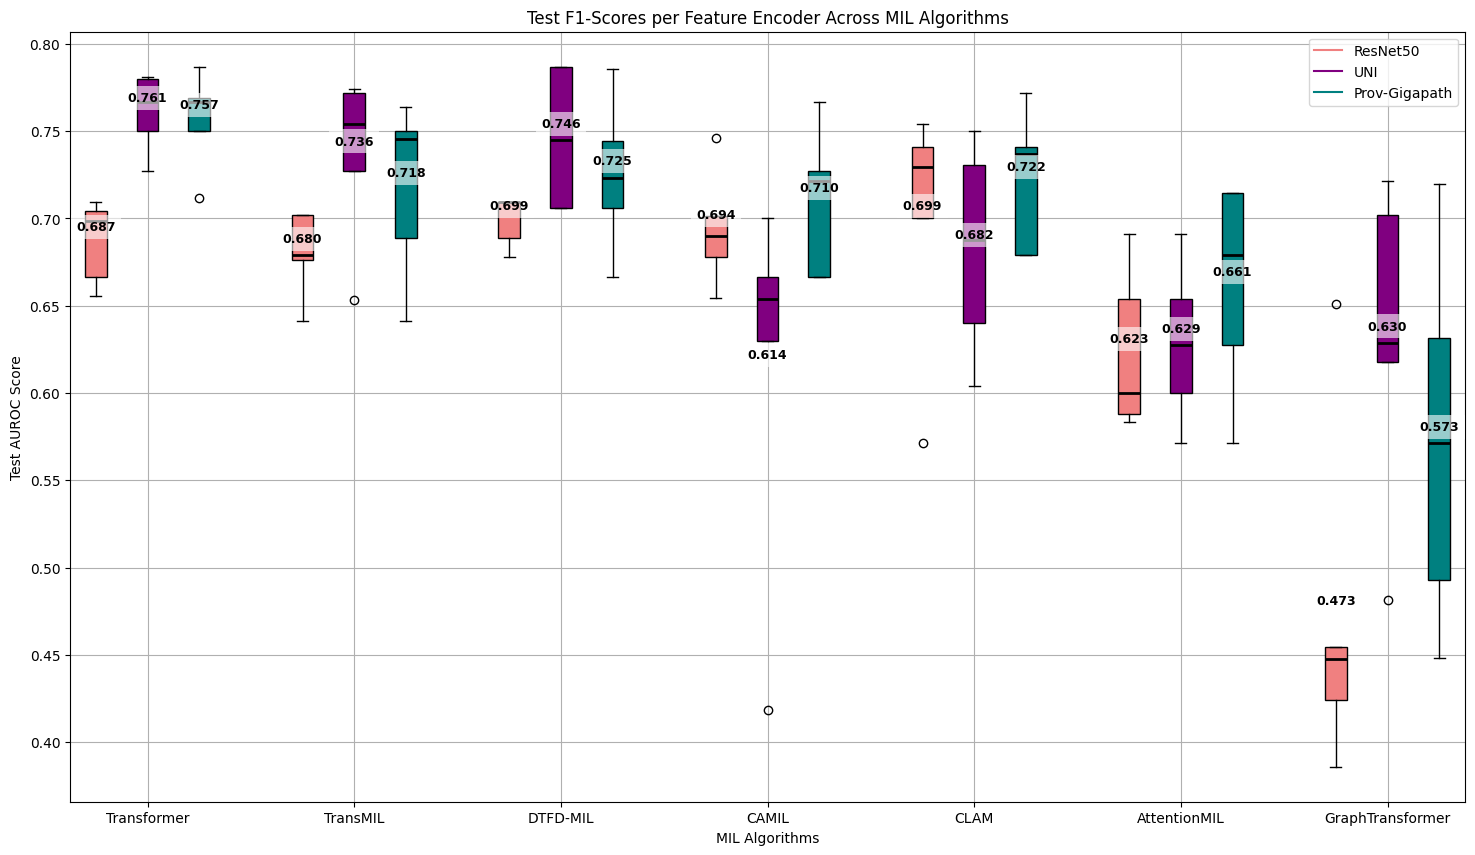

In [76]:
f1_scores = {
    models[0]: [
        (transformer_resnet50_auroc),
        (transformer_uni_auroc ),
        (transformer_gigapath_auroc)
    ],
    models[1]: [
        (transmil_resnet50_auroc),
        (transmil_uni_auroc),
        (transmil_gigapath_auroc)
    ],
    models[2]: [
        (dtfdmil_resnet50_auroc),
        (dtfdmil_uni_auroc),
        (dtfdmil_gigapath_auroc)
    ],
    models[3]: [
        (camil_resnet50_auroc),
        (camil_uni_auroc),
        (camil_gigapath_auroc)
    ],
    models[4]:[
        (clam_resnet50_auroc),
        (clam_uni_auroc),
        (clam_gigapath_auroc),
    ],
    models[5]: [
        (attentionmil_resnet50_auroc),
        (attentionmil_uni_auroc),
        (attentionmil_gigapath_auroc)
    ],
    models[6]:[
        (graphtransformer_resnet50_auroc),
        (graphtransformer_uni_auroc),
        (graphtransformer_gigapath_auroc),
    ]

}

plot_cross_validation_scores(f1_scores, 
                             title='Test F1-Scores per Feature Encoder Across MIL Algorithms',
                             ylabel='Test AUROC Score')

# TEST AUROC

In [72]:
transformer_resnet50_auroc = run_auroc_val_scores_resnet50['transformer']
transformer_uni_auroc = run_auroc_val_scores_uni['transformer']
transformer_gigapath_auroc = run_auroc_val_scores_gigapath['transformer']


transmil_resnet50_auroc = run_auroc_val_scores_resnet50['transmil']
transmil_uni_auroc = run_auroc_val_scores_uni['transmil']
transmil_gigapath_auroc = run_auroc_val_scores_gigapath['transmil']

dtfdmil_resnet50_auroc = run_auroc_val_scores_resnet50['dtfdmil']
dtfdmil_uni_auroc = run_auroc_val_scores_uni['dtfdmil']
dtfdmil_gigapath_auroc = run_auroc_val_scores_gigapath['dtfdmil']

camil_resnet50_auroc = run_auroc_val_scores_resnet50['camil']
camil_uni_auroc = run_auroc_val_scores_uni['camil']
camil_gigapath_auroc = run_auroc_val_scores_gigapath['camil']

clam_resnet50_auroc = run_auroc_val_scores_resnet50['clam']
clam_uni_auroc = run_auroc_val_scores_uni['clam']
clam_gigapath_auroc = run_auroc_val_scores_gigapath['clam']

attentionmil_resnet50_auroc = run_auroc_val_scores_resnet50['attentionmil']
attentionmil_uni_auroc = run_auroc_val_scores_uni['attentionmil']
attentionmil_gigapath_auroc = run_auroc_val_scores_gigapath['attentionmil']

graphtransformer_resnet50_auroc = run_auroc_val_scores_resnet50['graphtransformer']
graphtransformer_uni_auroc = run_auroc_val_scores_uni['graphtransformer']
graphtransformer_gigapath_auroc = run_auroc_val_scores_gigapath['graphtransformer']


In [73]:
# auroc_scores.keys()

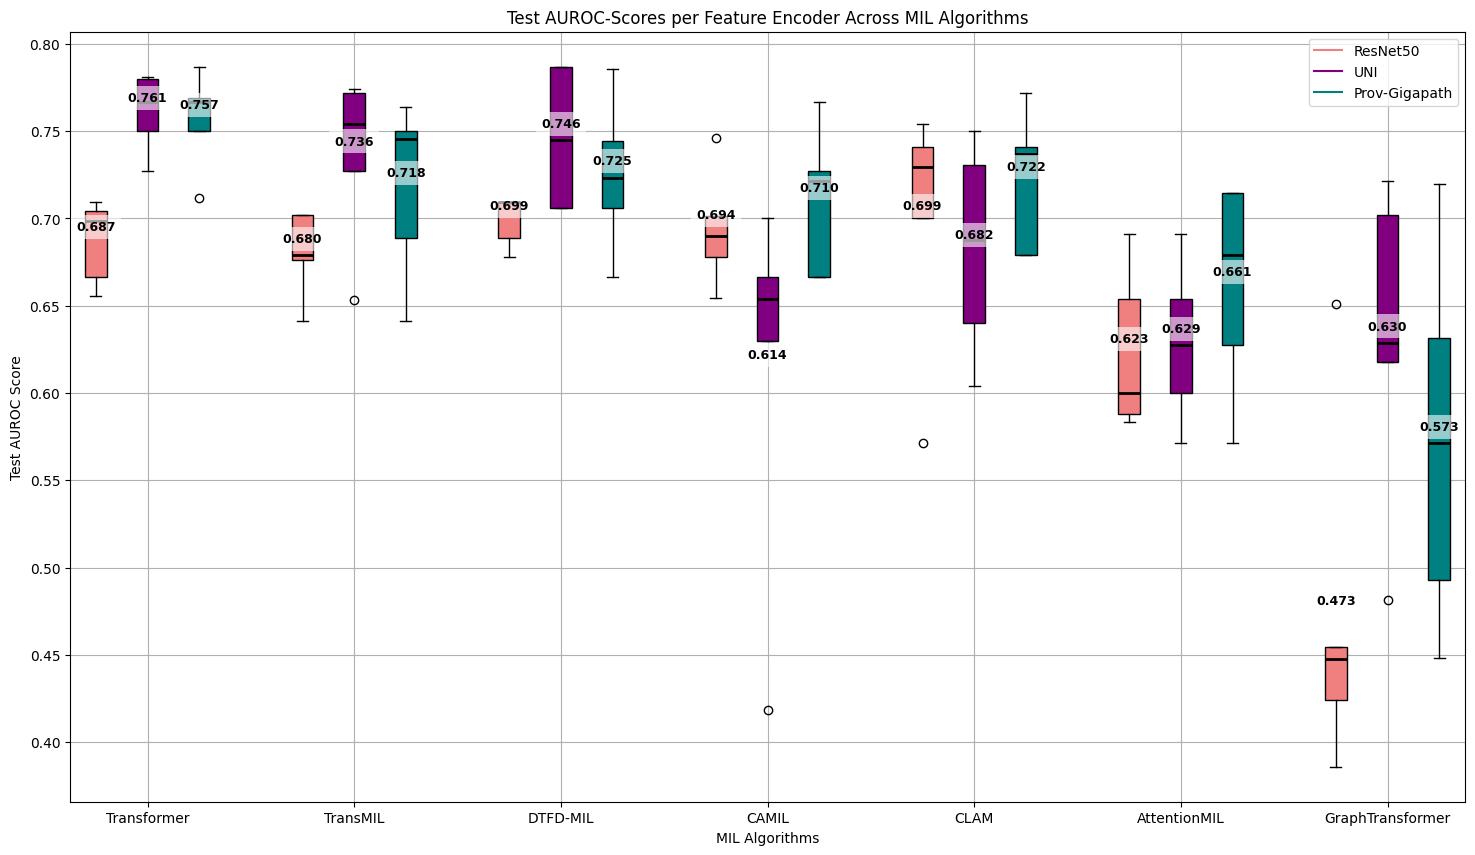

In [77]:
auroc_scores = {
    models[0]: [
        (transformer_resnet50_auroc),
        (transformer_uni_auroc ),
        (transformer_gigapath_auroc)
    ],
    models[1]: [
        (transmil_resnet50_auroc),
        (transmil_uni_auroc),
        (transmil_gigapath_auroc)
    ],
    models[2]: [
        (dtfdmil_resnet50_auroc),
        (dtfdmil_uni_auroc),
        (dtfdmil_gigapath_auroc)
    ],
    models[3]: [
        (camil_resnet50_auroc),
        (camil_uni_auroc),
        (camil_gigapath_auroc)
    ],
    models[4]:[
        (clam_resnet50_auroc),
        (clam_uni_auroc),
        (clam_gigapath_auroc),
    ],
    models[5]: [
        (attentionmil_resnet50_auroc),
        (attentionmil_uni_auroc),
        (attentionmil_gigapath_auroc)
    ],
    models[6]:[
        (graphtransformer_resnet50_auroc),
        (graphtransformer_uni_auroc),
        (graphtransformer_gigapath_auroc),
    ]

}

plot_cross_validation_scores(auroc_scores, 
                             title='Test AUROC-Scores per Feature Encoder Across MIL Algorithms',
                             ylabel='Test AUROC Score')

# Multimodal + Regression

In [ ]:
models = ['Transformer', 'TransMIL', 'DTFD-MIL', 'CAMIL', 'CLAM', 'AttentionMIL', 'GraphTransformer']